In [19]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

# Load environment variables
os.environ["LANGSMITH_PROJECT"] = "AgenticAIworkspace"
load_dotenv()

groq_key = os.getenv("GROQ_API_KEY")

# Initialize the LLM
llm = ChatGroq(api_key=groq_key, model="llama-3.1-8b-instant")

In [20]:

# Define a simple tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


In [21]:
tools = [add, multiply, divide]

In [22]:
llm_with_bind_tools = llm.bind_tools(tools)

In [23]:
# create Workflow using langgraph
from typing import TypedDict, Literal
from langgraph.checkpoint.memory import MemorySaver
from pydantic import Field, BaseModel
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import display, Image
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

sys_msg = SystemMessage(content="Your are a helpfull AI assistence for help arathmatic on a section")

def assistence(state: MessagesState):
    return {"messages": [llm_with_bind_tools.invoke([sys_msg] + state["messages"])]}

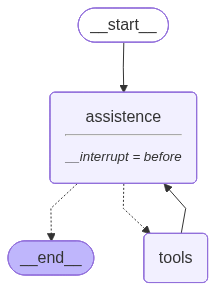

In [24]:
builder = StateGraph(MessagesState)

builder.add_node("assistence", assistence)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistence")
builder.add_conditional_edges("assistence", tools_condition)
builder.add_edge("tools", "assistence")

memory = MemorySaver()
graph_builder = builder.compile(interrupt_before=["assistence"],checkpointer=memory)

# Show the workflow
display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [25]:
thread = {"configurable": {"thread_id": "123"}}
initial_msg = {"messages": HumanMessage(content="multiply 2 and 3")}

In [ ]:
# intreapt the flow
for event in graph_builder.stream(initial_msg, thread, stream_mode="values"):
    print(event["messages"][-1])

content='multiply 2 and 3' additional_kwargs={} response_metadata={} id='6274b09d-a060-40a5-aefc-5662adeb5fdd'


In [27]:
for event in graph_builder.stream(None, thread, stream_mode="values"):
    print(event["messages"][-1])

content='multiply 2 and 3' additional_kwargs={} response_metadata={} id='6274b09d-a060-40a5-aefc-5662adeb5fdd'
content='' additional_kwargs={'tool_calls': [{'id': '1y9kb5evn', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 372, 'total_tokens': 391, 'completion_time': 0.028684924, 'prompt_time': 0.020803401, 'queue_time': 0.052166018, 'total_time': 0.049488325}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--57e629b6-5923-4f34-b71c-73a044923208-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '1y9kb5evn', 'type': 'tool_call'}] usage_metadata={'input_tokens': 372, 'output_tokens': 19, 'total_tokens': 391}
content='6' name='multiply' id='74e036a2-1f2a-4fab-a937-6aaf0ef163c6' tool_call_id='1y9kb5evn'


get the human - feedback

In [28]:


initial_msg = {"messages": HumanMessage(content="multiply 2 and 3")}
thread = {"configurable": {"thread_id": "1"}}

In [29]:
# intreapt the flow
for event in graph_builder.stream(initial_msg, thread, stream_mode="values"):
    print(event["messages"][-1])

content='multiply 2 and 3' additional_kwargs={} response_metadata={} id='19eea266-d408-42e6-b9bb-bd96bfc20aef'


In [32]:
state = graph_builder.get_state(thread)
state.next

('assistence',)

In [33]:
graph_builder.update_state(thread, {"messages":HumanMessage(content="No. Dont multiply the 2 and 3") })

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0ada96-8ef9-6ce4-8001-ef6885f8f06a'}}

In [34]:
state = graph_builder.get_state(thread)
state.next

('assistence',)

In [35]:
for event in graph_builder.stream(None, thread, stream_mode="values"):
    print(event["messages"][-1])

content='No. Dont multiply the 2 and 3' additional_kwargs={} response_metadata={} id='960c0a9f-1626-42ce-b534-8871304a2d01'
content='' additional_kwargs={'tool_calls': [{'id': 'g2pxyb500', 'function': {'arguments': '{"a":4,"b":5}', 'name': 'multiply'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 387, 'total_tokens': 407, 'completion_time': 0.039224526, 'prompt_time': 0.027744018, 'queue_time': 0.052498911, 'total_time': 0.066968544}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--4815e66a-9410-49b5-a8f1-42abf4fa09cd-0' tool_calls=[{'name': 'multiply', 'args': {'a': 4, 'b': 5}, 'id': 'g2pxyb500', 'type': 'tool_call'}] usage_metadata={'input_tokens': 387, 'output_tokens': 20, 'total_tokens': 407}
content='20' name='multiply' id='4d3dde90-50ee-416b-9b9a-b875cf7cedc8' tool_call_id='g2pxyb500'
